In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import yaml
import pypsa

In [9]:
ics = yaml.safe_load(
    open(
        Path.cwd().parent / 'data' / 'interconnection_helpers.yaml'
        )
    )['interconnection_mapper']

In [1]:
years = range(2022, 2025)

days = [
    '{}-03-01',
    '{}-03-02',
    '{}-03-03',
    '{}-03-04',
    '{}-03-05',
    '{}-03-06',
    '{}-03-07',
    '{}-03-08',
    '{}-03-09',
    '{}-03-10',
]



In [5]:
bmus = pd.read_csv(
    Path.cwd().parent / 'data' / 'preprocessed' / 'prepared_bmus.csv',
    index_col=0
    )


bmus

,carrier,bus,lon,lat
NationalGridBmUnit,,,,
IBG-EGEN1,interconnector,4969,0.6530000000000001,51.46000000000001
IBG-ENGI1,interconnector,4969,0.6530000000000001,51.46000000000001
IBG-RSQ1,interconnector,4969,0.6530000000000001,51.46000000000001
IVD-VKL1,interconnector,7909,-0.221,52.931
IVG-VKL1,interconnector,7909,-0.221,52.931
...,...,...,...,...
SFERD-1,demand_flex,distributed,distributed,distributed
EAS-SEL01,demand_flex,distributed,distributed,distributed
SEE-PGU01,demand_flex,distributed,distributed,distributed


In [29]:
def get_intercon_flows(df):
    df = df.copy()

    flows = pd.DataFrame(index=df.index)

    for ic, shorthands in ics.items():
        if ic == 'Nemo':
            continue

        matching_cols = [col for col in df.columns if any(col.startswith(prefix) for prefix in shorthands)]
        flows[ic] = df[matching_cols].sum(axis=1)

    return flows


INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storag

max absolute derivative model: 4.28804027851835
max absolute derivative flows: 2.9005


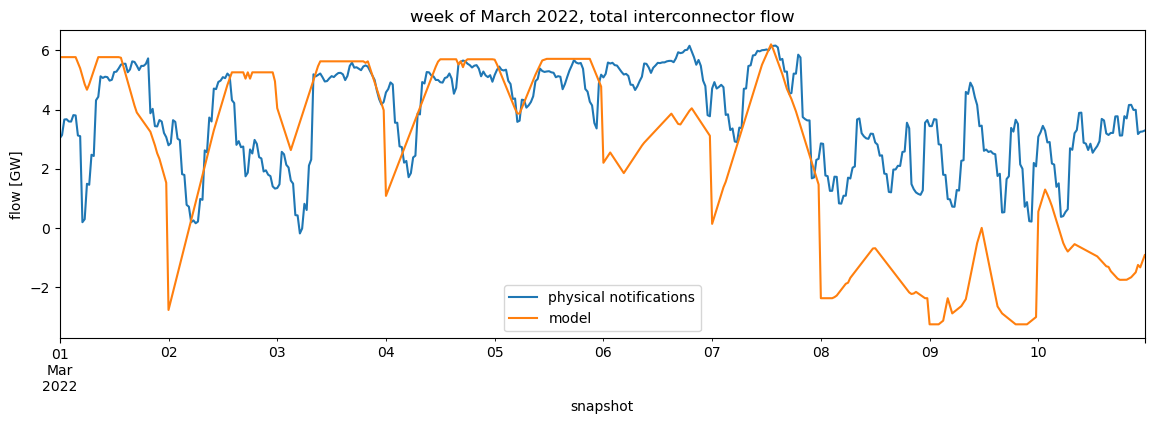

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storag

max absolute derivative model: 7.141838543041098
max absolute derivative flows: 3.5709999999999997


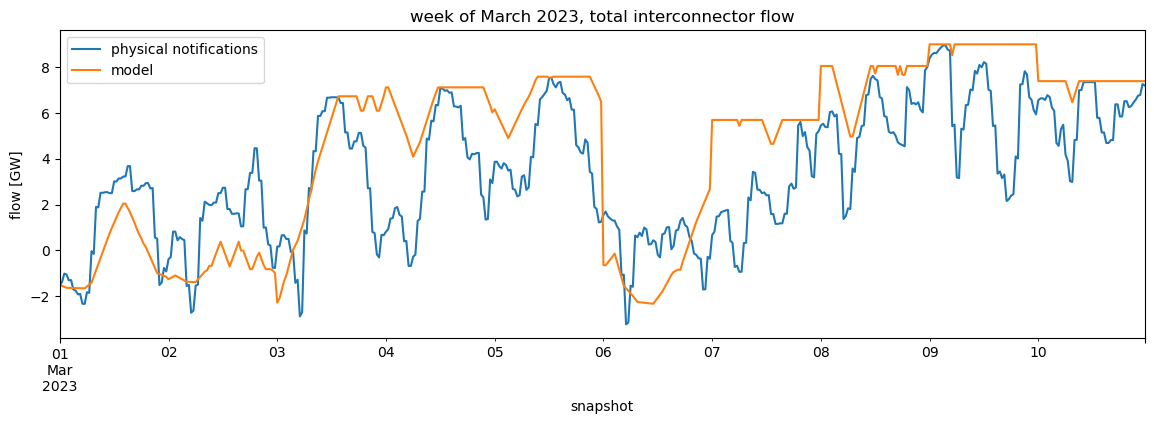

INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storag

max absolute derivative model: 3.2478788147723217
max absolute derivative flows: 3.0115000000000007


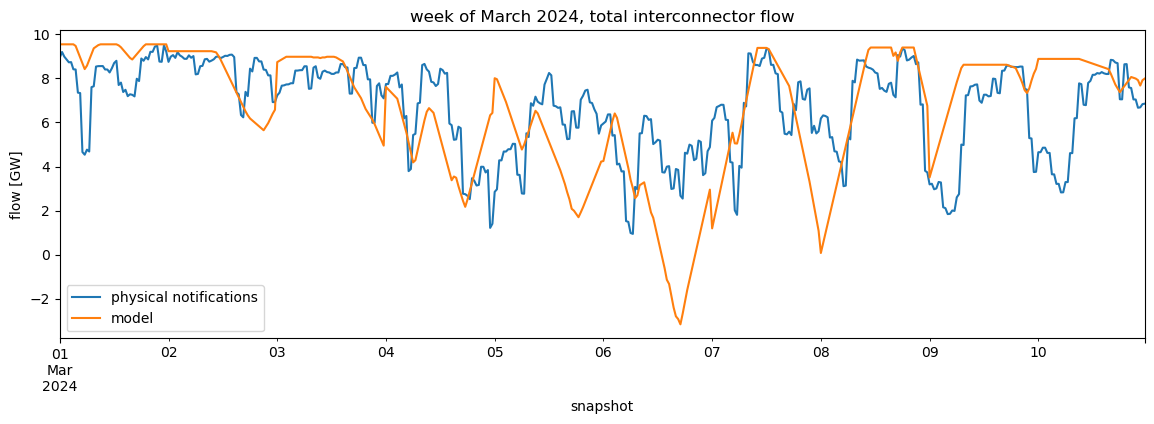

In [55]:

pns = {}
nemos = {}

for year in years:
    pns[year] = list()
    nemos[year] = list()

    model_flow = list()

    for day in days:

        ss_pns = pd.read_csv(f'../data/base/{day.format(year)}/physical_notifications.csv', index_col=0, parse_dates=True)
        nemo_ss = pd.read_csv(f'../data/base/{day.format(year)}/nemo_powerflow.csv', index_col=0, parse_dates=True)

        pns[year].append(ss_pns)
        nemos[year].append(nemo_ss)

        n = pypsa.Network(
            Path.cwd().parent / 'results' / day.format(year) / 'network_flex_s_national_solved.nc'
        )

        model_flow.append(n.links_t.p0.loc[:, n.links.index[n.links.carrier == 'interconnector']].sum(axis=1))


    pns[year] = pd.concat(pns[year])
    nemos[year] = pd.concat(nemos[year])

    model_flow = pd.concat(model_flow)
    
    flows = get_intercon_flows(pns[year])
    flows['nemo '] = nemos[year].iloc[:,0]

    flows = flows.mul(1e-3).sum(axis=1)
    model_flow = model_flow.mul(1e-3)
    
    # max absolute derivative for both
    max_abs_derivative = model_flow.diff().abs().max()
    max_abs_derivative_flows = flows.diff().abs().max()
    print(f'max absolute derivative model: {max_abs_derivative}')
    print(f'max absolute derivative flows: {max_abs_derivative_flows}')

    fig, ax = plt.subplots(figsize=(14, 4))

    flows.plot(ax=ax, label='physical notifications')
    model_flow.plot(ax=ax, label='model')


    ax.set_title(f'week of March {year}, total interconnector flow')
    ax.set_ylabel('flow [GW]')

    ax.legend()

    # plt.savefig(f'prefix_{year}_intercon_flow.pdf', bbox_inches='tight')
    plt.show()


INFO:pypsa.io:Imported network network_flex_s_national_solved.nc has buses, carriers, generators, links, loads, storage_units


<Axes: xlabel='snapshot'>

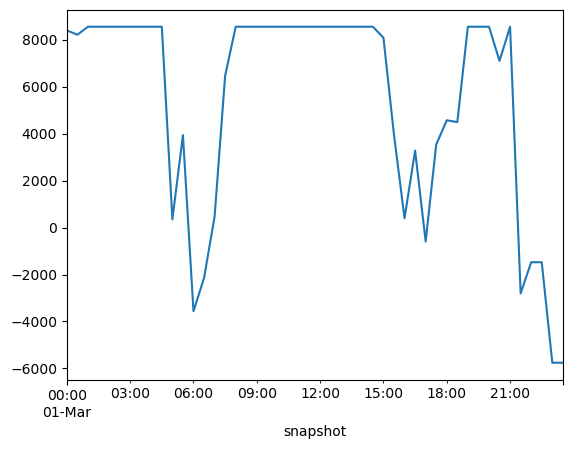

In [49]:
n = pypsa.Network(
    Path.cwd().parent / 'results' / '2022-03-01' / 'network_flex_s_national_solved.nc'
)

n.links_t.p0.loc[:, n.links.index[n.links.carrier == 'interconnector']].sum(axis=1).plot()
